<Body>   
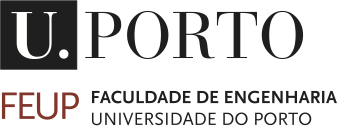   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using Vanilla GAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


In [5]:
class FraudDataset(Dataset):

  def __init__(self, dataframe, fraud = True):
    scaler = StandardScaler()
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]

    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)

  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [6]:
train_dataloader = DataLoader(creditData, batch_size=32, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=32, drop_last=True)

## Conditional Generative Adversarial Network

### Architecture

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(latent_dim, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(16, nr_features),
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(nr_features, 256),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(16, 1),

        )
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

###  Training the model

In [9]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 16
        self.n_critic = 1
        self.clip_value = 0.0001
        self.cur_batch_size = 64
        self.latent_dim = 128
        self.criterion = nn.BCELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(self.device)
        self.D = Discriminator(nr_features=self.dataset.features).to(self.device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), self.lr)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), self.lr)





    def train_generator(self,real_data):
        # Clear generator gradients
        self.g_optimizer.zero_grad()

        fake_targets = torch.ones(real_data.size(0)).to(self.device)
        fake_targets = fake_targets - 0.1

        # Random noise from a uniform distribution
        latent_space_samples = torch.randn(real_data.size(0), self.latent_dim).to(self.device)
        generated_data = self.G(latent_space_samples)  # Fake data generated by the generator
        fake_preds = self.D(generated_data).reshape(-1)

        g_loss = self.criterion(fake_preds, fake_targets)
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss, generated_data

    def train_discriminator(self, real_data, real_labels):
        self.d_optimizer.zero_grad()
        real_labels = torch.ones(real_data.size(0)).to(self.device) * 0.9

        real_preds = self.D(real_data).reshape(-1)
        d_loss_real = self.criterion(real_preds, real_labels)

        fake_labels = torch.zeros(self.cur_batch_size).to(self.device) * 0.1

        # random noise from uniform distribution
        latent_space_samples = torch.randn(self.cur_batch_size, self.latent_dim).to(self.device)


        generated_data = self.G(latent_space_samples).detach()
        fake_preds = self.D(generated_data).reshape(-1)
        d_loss_fake = self.criterion(fake_preds, fake_labels)


        loss = d_loss_real + d_loss_fake

        # Compute gradients
        loss.backward()
        # Adjust the parameters using backprop
        self.d_optimizer.step()


        return loss

    def train(self,real_data, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(0,epochs):
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                real_data, real_labels = real_data.to(self.device), real_labels.to(self.device)
                # Train discriminator
                d_error = self.train_discriminator(real_data, real_labels)
                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error, _ = self.train_generator(real_data)
                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch+1, epochs, i+1, len(self.dataloader), d_error.item(), g_error.item()))

        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(self.device)
            gen = self.G(z)
            return gen.cpu().numpy()

In [10]:
gan = GAN(df_train)

In [11]:
losses_gen, losses_dis = gan.train(df_train, epochs=1000)

Epoch [1/1000], Step [25/25], d_loss: 17.8633, g_loss: 0.6279 

Epoch [2/1000], Step [25/25], d_loss: 39.5901, g_loss: 0.6372 

Epoch [3/1000], Step [25/25], d_loss: 9.9183, g_loss: 0.6362 

Epoch [4/1000], Step [25/25], d_loss: 18.7642, g_loss: 0.6381 

Epoch [5/1000], Step [25/25], d_loss: 10.8336, g_loss: 0.6500 

Epoch [6/1000], Step [25/25], d_loss: 13.6945, g_loss: 0.6496 

Epoch [7/1000], Step [25/25], d_loss: 15.1076, g_loss: 0.6486 

Epoch [8/1000], Step [25/25], d_loss: 19.3026, g_loss: 0.6464 

Epoch [9/1000], Step [25/25], d_loss: 18.7517, g_loss: 0.6440 

Epoch [10/1000], Step [25/25], d_loss: 10.7446, g_loss: 0.6539 

Epoch [11/1000], Step [25/25], d_loss: 10.7403, g_loss: 0.6612 

Epoch [12/1000], Step [25/25], d_loss: 9.9014, g_loss: 0.6521 

Epoch [13/1000], Step [25/25], d_loss: 10.7389, g_loss: 0.6500 

Epoch [14/1000], Step [25/25], d_loss: 10.7385, g_loss: 0.6627 

Epoch [15/1000], Step [25/25], d_loss: 10.7381, g_loss: 0.6617 

Epoch [16/1000], Step [25/25], d_los

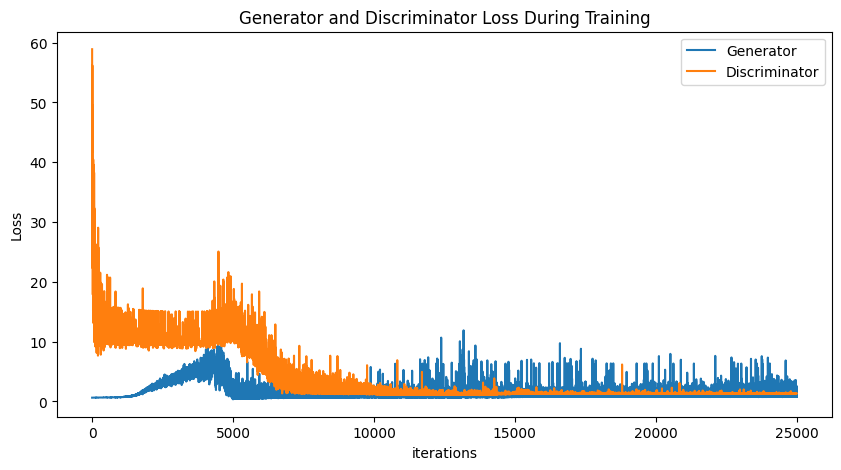

In [12]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.cpu().detach().numpy() for i in losses_gen]
    losses_dis = [i.cpu().detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

In [13]:
#define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
gan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, gan_df], ignore_index=True)

In [14]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
223361,143352.0,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,9.99,0
165061,117173.0,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,45.90,0
238186,149565.0,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,11.99,0
150562,93670.0,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,117.44,0
138452,82655.0,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,25.76,0


In [15]:
df_concat['Class'].value_counts()

1.0    227845
0.0    227451
Name: Class, dtype: int64

## Model evaluation

In [16]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score
from imblearn.metrics import classification_report_imbalanced


def common_metrics(y_true, y_pred, y_prob):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
    RocCurveDisplay.from_predictions(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    #
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_true, y_prob, ax=ax)
    # P / (P + N)
    ap_frauds = (len(y_true[y_true == 1]) / len(y_true))
    plt.axhline(y=ap_frauds, color='r', linestyle='-')
    plt.show()
    #
    print(classification_report_imbalanced(y_true, y_pred))
    print("AUPRC:", auc(recall, precision))
    print("AP:", average_precision_score(y_true, y_prob))

### Deep Neural Network

In [17]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [18]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(tqdm(self.dataloader)):
                x,y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch+1, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
            input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
            y_true = torch.Tensor(test_df['Class'].values).to(device)
            #preds = self.predict(input)
            preds = np.array([])
            dataloader_test = DataLoader(TensorDataset(input, y_true), batch_size=64, shuffle=False)

            for (inp, _) in dataloader_test:
                pred = self.predict(inp)
                preds = np.concatenate((preds, pred), axis=None)
            labels = np.zeros_like(preds)
            labels[preds >= confidence] = 1
            common_metrics(y_true.cpu().numpy(), labels,preds)

100%|██████████| 7114/7114 [00:22<00:00, 315.37it/s]


[Epoch 1/300] loss: 4.264046


100%|██████████| 7114/7114 [00:21<00:00, 327.26it/s]


[Epoch 2/300] loss: 3.099642


100%|██████████| 7114/7114 [00:22<00:00, 310.90it/s]


[Epoch 3/300] loss: 2.632950


100%|██████████| 7114/7114 [00:22<00:00, 317.37it/s]


[Epoch 4/300] loss: 2.418127


100%|██████████| 7114/7114 [00:23<00:00, 302.84it/s]


[Epoch 5/300] loss: 2.265304


100%|██████████| 7114/7114 [00:22<00:00, 311.34it/s]


[Epoch 6/300] loss: 2.227742


100%|██████████| 7114/7114 [00:22<00:00, 313.04it/s]


[Epoch 7/300] loss: 2.111600


100%|██████████| 7114/7114 [00:23<00:00, 305.67it/s]


[Epoch 8/300] loss: 1.961603


100%|██████████| 7114/7114 [00:22<00:00, 318.64it/s]


[Epoch 9/300] loss: 1.790434


100%|██████████| 7114/7114 [00:23<00:00, 303.52it/s]


[Epoch 10/300] loss: 1.666383


100%|██████████| 7114/7114 [00:23<00:00, 305.16it/s]


[Epoch 11/300] loss: 1.710976


100%|██████████| 7114/7114 [00:22<00:00, 310.80it/s]


[Epoch 12/300] loss: 1.591486


100%|██████████| 7114/7114 [00:23<00:00, 301.28it/s]


[Epoch 13/300] loss: 1.790508


100%|██████████| 7114/7114 [00:22<00:00, 315.49it/s]


[Epoch 14/300] loss: 1.453265


100%|██████████| 7114/7114 [00:23<00:00, 303.98it/s]


[Epoch 15/300] loss: 1.421575


100%|██████████| 7114/7114 [00:23<00:00, 300.98it/s]


[Epoch 16/300] loss: 1.728588


100%|██████████| 7114/7114 [00:22<00:00, 311.25it/s]


[Epoch 17/300] loss: 1.336109


100%|██████████| 7114/7114 [00:23<00:00, 301.83it/s]


[Epoch 18/300] loss: 1.202731


100%|██████████| 7114/7114 [00:23<00:00, 306.33it/s]


[Epoch 19/300] loss: 1.239315


100%|██████████| 7114/7114 [00:22<00:00, 309.35it/s]


[Epoch 20/300] loss: 1.199193


100%|██████████| 7114/7114 [00:23<00:00, 301.51it/s]


[Epoch 21/300] loss: 1.193814


100%|██████████| 7114/7114 [00:22<00:00, 314.60it/s]


[Epoch 22/300] loss: 1.147471


100%|██████████| 7114/7114 [00:23<00:00, 299.87it/s]


[Epoch 23/300] loss: 1.127922


100%|██████████| 7114/7114 [00:23<00:00, 302.20it/s]


[Epoch 24/300] loss: 1.034380


100%|██████████| 7114/7114 [00:22<00:00, 310.88it/s]


[Epoch 25/300] loss: 1.008148


100%|██████████| 7114/7114 [00:23<00:00, 298.49it/s]


[Epoch 26/300] loss: 1.023415


100%|██████████| 7114/7114 [00:22<00:00, 309.43it/s]


[Epoch 27/300] loss: 0.987461


100%|██████████| 7114/7114 [00:23<00:00, 305.83it/s]


[Epoch 28/300] loss: 1.003274


100%|██████████| 7114/7114 [00:23<00:00, 299.40it/s]


[Epoch 29/300] loss: 0.947690


100%|██████████| 7114/7114 [00:22<00:00, 312.89it/s]


[Epoch 30/300] loss: 1.079320


100%|██████████| 7114/7114 [00:23<00:00, 302.32it/s]


[Epoch 31/300] loss: 1.134475


100%|██████████| 7114/7114 [00:23<00:00, 302.77it/s]


[Epoch 32/300] loss: 1.040531


100%|██████████| 7114/7114 [00:22<00:00, 311.93it/s]


[Epoch 33/300] loss: 0.997601


100%|██████████| 7114/7114 [00:23<00:00, 301.14it/s]


[Epoch 34/300] loss: 0.970610


100%|██████████| 7114/7114 [00:22<00:00, 311.68it/s]


[Epoch 35/300] loss: 0.901213


100%|██████████| 7114/7114 [00:23<00:00, 304.87it/s]


[Epoch 36/300] loss: 0.926978


100%|██████████| 7114/7114 [00:23<00:00, 304.19it/s]


[Epoch 37/300] loss: 0.878618


100%|██████████| 7114/7114 [00:22<00:00, 317.43it/s]


[Epoch 38/300] loss: 0.861580


100%|██████████| 7114/7114 [00:23<00:00, 302.94it/s]


[Epoch 39/300] loss: 0.840488


100%|██████████| 7114/7114 [00:23<00:00, 308.76it/s]


[Epoch 40/300] loss: 0.798078


100%|██████████| 7114/7114 [00:22<00:00, 310.08it/s]


[Epoch 41/300] loss: 0.918265


100%|██████████| 7114/7114 [00:23<00:00, 304.12it/s]


[Epoch 42/300] loss: 0.761635


100%|██████████| 7114/7114 [00:22<00:00, 314.66it/s]


[Epoch 43/300] loss: 0.906072


100%|██████████| 7114/7114 [00:23<00:00, 300.92it/s]


[Epoch 44/300] loss: 0.793618


100%|██████████| 7114/7114 [00:23<00:00, 300.97it/s]


[Epoch 45/300] loss: 0.785507


100%|██████████| 7114/7114 [00:22<00:00, 312.18it/s]


[Epoch 46/300] loss: 0.784119


100%|██████████| 7114/7114 [00:23<00:00, 301.95it/s]


[Epoch 47/300] loss: 0.747303


100%|██████████| 7114/7114 [00:22<00:00, 316.34it/s]


[Epoch 48/300] loss: 0.778797


100%|██████████| 7114/7114 [00:23<00:00, 303.11it/s]


[Epoch 49/300] loss: 0.766233


100%|██████████| 7114/7114 [00:23<00:00, 300.49it/s]


[Epoch 50/300] loss: 0.742926


100%|██████████| 7114/7114 [00:22<00:00, 315.38it/s]


[Epoch 51/300] loss: 0.752222


100%|██████████| 7114/7114 [00:23<00:00, 302.35it/s]


[Epoch 52/300] loss: 1.331372


100%|██████████| 7114/7114 [00:23<00:00, 307.23it/s]


[Epoch 53/300] loss: 0.809245


100%|██████████| 7114/7114 [00:23<00:00, 306.13it/s]


[Epoch 54/300] loss: 0.715647


100%|██████████| 7114/7114 [00:23<00:00, 300.77it/s]


[Epoch 55/300] loss: 0.799270


100%|██████████| 7114/7114 [00:22<00:00, 314.12it/s]


[Epoch 56/300] loss: 0.847780


100%|██████████| 7114/7114 [00:23<00:00, 296.72it/s]


[Epoch 57/300] loss: 0.662238


100%|██████████| 7114/7114 [00:23<00:00, 301.50it/s]


[Epoch 58/300] loss: 0.687600


100%|██████████| 7114/7114 [00:22<00:00, 313.80it/s]


[Epoch 59/300] loss: 0.714479


100%|██████████| 7114/7114 [00:23<00:00, 301.69it/s]


[Epoch 60/300] loss: 0.702962


100%|██████████| 7114/7114 [00:23<00:00, 309.26it/s]


[Epoch 61/300] loss: 0.670733


100%|██████████| 7114/7114 [00:23<00:00, 302.26it/s]


[Epoch 62/300] loss: 0.837096


100%|██████████| 7114/7114 [00:23<00:00, 300.36it/s]


[Epoch 63/300] loss: 0.640524


100%|██████████| 7114/7114 [00:22<00:00, 313.78it/s]


[Epoch 64/300] loss: 0.661879


100%|██████████| 7114/7114 [00:23<00:00, 301.98it/s]


[Epoch 65/300] loss: 0.666635


100%|██████████| 7114/7114 [00:23<00:00, 303.68it/s]


[Epoch 66/300] loss: 0.685360


100%|██████████| 7114/7114 [00:23<00:00, 309.08it/s]


[Epoch 67/300] loss: 0.643983


100%|██████████| 7114/7114 [00:23<00:00, 299.59it/s]


[Epoch 68/300] loss: 0.709123


100%|██████████| 7114/7114 [00:22<00:00, 311.10it/s]


[Epoch 69/300] loss: 0.637603


100%|██████████| 7114/7114 [00:23<00:00, 300.87it/s]


[Epoch 70/300] loss: 0.916583


100%|██████████| 7114/7114 [00:23<00:00, 299.31it/s]


[Epoch 71/300] loss: 0.636371


100%|██████████| 7114/7114 [00:22<00:00, 314.52it/s]


[Epoch 72/300] loss: 0.997131


100%|██████████| 7114/7114 [00:23<00:00, 300.87it/s]


[Epoch 73/300] loss: 1.501439


100%|██████████| 7114/7114 [00:23<00:00, 304.67it/s]


[Epoch 74/300] loss: 0.639018


100%|██████████| 7114/7114 [00:23<00:00, 306.13it/s]


[Epoch 75/300] loss: 0.726877


100%|██████████| 7114/7114 [00:23<00:00, 301.52it/s]


[Epoch 76/300] loss: 0.643838


100%|██████████| 7114/7114 [00:22<00:00, 315.35it/s]


[Epoch 77/300] loss: 0.799515


100%|██████████| 7114/7114 [00:23<00:00, 303.52it/s]


[Epoch 78/300] loss: 0.773787


100%|██████████| 7114/7114 [00:23<00:00, 304.98it/s]


[Epoch 79/300] loss: 0.713664


100%|██████████| 7114/7114 [00:22<00:00, 312.46it/s]


[Epoch 80/300] loss: 0.699058


100%|██████████| 7114/7114 [00:23<00:00, 301.79it/s]


[Epoch 81/300] loss: 0.774185


100%|██████████| 7114/7114 [00:22<00:00, 313.65it/s]


[Epoch 82/300] loss: 0.645665


100%|██████████| 7114/7114 [00:23<00:00, 303.82it/s]


[Epoch 83/300] loss: 0.639563


100%|██████████| 7114/7114 [00:23<00:00, 300.53it/s]


[Epoch 84/300] loss: 0.625098


100%|██████████| 7114/7114 [00:22<00:00, 313.56it/s]


[Epoch 85/300] loss: 0.671204


100%|██████████| 7114/7114 [00:23<00:00, 302.37it/s]


[Epoch 86/300] loss: 0.794305


100%|██████████| 7114/7114 [00:23<00:00, 307.94it/s]


[Epoch 87/300] loss: 0.667169


100%|██████████| 7114/7114 [00:22<00:00, 309.82it/s]


[Epoch 88/300] loss: 0.622127


100%|██████████| 7114/7114 [00:23<00:00, 304.54it/s]


[Epoch 89/300] loss: 0.597821


100%|██████████| 7114/7114 [00:22<00:00, 318.30it/s]


[Epoch 90/300] loss: 0.626957


100%|██████████| 7114/7114 [00:23<00:00, 303.01it/s]


[Epoch 91/300] loss: 0.621500


100%|██████████| 7114/7114 [00:23<00:00, 307.40it/s]


[Epoch 92/300] loss: 0.643962


100%|██████████| 7114/7114 [00:22<00:00, 311.08it/s]


[Epoch 93/300] loss: 0.595597


100%|██████████| 7114/7114 [00:23<00:00, 305.04it/s]


[Epoch 94/300] loss: 0.611311


100%|██████████| 7114/7114 [00:22<00:00, 315.73it/s]


[Epoch 95/300] loss: 0.983224


100%|██████████| 7114/7114 [00:23<00:00, 302.55it/s]


[Epoch 96/300] loss: 0.607022


100%|██████████| 7114/7114 [00:23<00:00, 302.47it/s]


[Epoch 97/300] loss: 0.597146


100%|██████████| 7114/7114 [00:22<00:00, 313.20it/s]


[Epoch 98/300] loss: 0.618461


100%|██████████| 7114/7114 [00:23<00:00, 301.97it/s]


[Epoch 99/300] loss: 0.647637


100%|██████████| 7114/7114 [00:22<00:00, 313.25it/s]


[Epoch 100/300] loss: 0.617009


100%|██████████| 7114/7114 [00:23<00:00, 304.42it/s]


[Epoch 101/300] loss: 0.596227


100%|██████████| 7114/7114 [00:23<00:00, 300.83it/s]


[Epoch 102/300] loss: 0.613715


100%|██████████| 7114/7114 [00:22<00:00, 315.74it/s]


[Epoch 103/300] loss: 0.800836


100%|██████████| 7114/7114 [00:23<00:00, 301.97it/s]


[Epoch 104/300] loss: 0.551301


100%|██████████| 7114/7114 [00:23<00:00, 309.10it/s]


[Epoch 105/300] loss: 0.567599


100%|██████████| 7114/7114 [00:23<00:00, 306.89it/s]


[Epoch 106/300] loss: 0.591332


100%|██████████| 7114/7114 [00:23<00:00, 303.32it/s]


[Epoch 107/300] loss: 0.552068


100%|██████████| 7114/7114 [00:22<00:00, 315.41it/s]


[Epoch 108/300] loss: 0.586642


100%|██████████| 7114/7114 [00:23<00:00, 302.11it/s]


[Epoch 109/300] loss: 0.632463


100%|██████████| 7114/7114 [00:23<00:00, 302.66it/s]


[Epoch 110/300] loss: 0.561220


100%|██████████| 7114/7114 [00:22<00:00, 312.57it/s]


[Epoch 111/300] loss: 0.565131


100%|██████████| 7114/7114 [00:23<00:00, 301.55it/s]


[Epoch 112/300] loss: 0.565709


100%|██████████| 7114/7114 [00:22<00:00, 312.92it/s]


[Epoch 113/300] loss: 0.592937


100%|██████████| 7114/7114 [00:23<00:00, 305.42it/s]


[Epoch 114/300] loss: 0.575627


100%|██████████| 7114/7114 [00:23<00:00, 302.57it/s]


[Epoch 115/300] loss: 0.593698


100%|██████████| 7114/7114 [00:22<00:00, 314.00it/s]


[Epoch 116/300] loss: 0.561091


100%|██████████| 7114/7114 [00:23<00:00, 301.80it/s]


[Epoch 117/300] loss: 0.579448


100%|██████████| 7114/7114 [00:22<00:00, 309.60it/s]


[Epoch 118/300] loss: 0.540828


100%|██████████| 7114/7114 [00:23<00:00, 307.67it/s]


[Epoch 119/300] loss: 0.546908


100%|██████████| 7114/7114 [00:23<00:00, 300.23it/s]


[Epoch 120/300] loss: 0.905012


100%|██████████| 7114/7114 [00:22<00:00, 312.18it/s]


[Epoch 121/300] loss: 0.552698


100%|██████████| 7114/7114 [00:23<00:00, 297.50it/s]


[Epoch 122/300] loss: 0.552456


100%|██████████| 7114/7114 [00:23<00:00, 299.48it/s]


[Epoch 123/300] loss: 0.613257


100%|██████████| 7114/7114 [00:22<00:00, 312.10it/s]


[Epoch 124/300] loss: 0.553070


100%|██████████| 7114/7114 [00:23<00:00, 300.77it/s]


[Epoch 125/300] loss: 0.576183


100%|██████████| 7114/7114 [00:22<00:00, 309.37it/s]


[Epoch 126/300] loss: 0.561409


100%|██████████| 7114/7114 [00:23<00:00, 307.04it/s]


[Epoch 127/300] loss: 0.589397


100%|██████████| 7114/7114 [00:23<00:00, 303.48it/s]


[Epoch 128/300] loss: 0.551626


100%|██████████| 7114/7114 [00:22<00:00, 316.81it/s]


[Epoch 129/300] loss: 0.623867


100%|██████████| 7114/7114 [00:23<00:00, 301.13it/s]


[Epoch 130/300] loss: 0.587399


100%|██████████| 7114/7114 [00:23<00:00, 305.78it/s]


[Epoch 131/300] loss: 0.559650


100%|██████████| 7114/7114 [00:22<00:00, 310.17it/s]


[Epoch 132/300] loss: 0.533204


100%|██████████| 7114/7114 [00:23<00:00, 301.78it/s]


[Epoch 133/300] loss: 0.553518


100%|██████████| 7114/7114 [00:22<00:00, 313.49it/s]


[Epoch 134/300] loss: 0.554406


100%|██████████| 7114/7114 [00:23<00:00, 303.17it/s]


[Epoch 135/300] loss: 0.537479


100%|██████████| 7114/7114 [00:23<00:00, 304.56it/s]


[Epoch 136/300] loss: 0.584431


100%|██████████| 7114/7114 [00:23<00:00, 309.19it/s]


[Epoch 137/300] loss: 0.518787


100%|██████████| 7114/7114 [00:23<00:00, 300.46it/s]


[Epoch 138/300] loss: 0.552067


100%|██████████| 7114/7114 [00:23<00:00, 306.19it/s]


[Epoch 139/300] loss: 0.530559


100%|██████████| 7114/7114 [00:23<00:00, 306.35it/s]


[Epoch 140/300] loss: 0.576880


100%|██████████| 7114/7114 [00:23<00:00, 299.62it/s]


[Epoch 141/300] loss: 0.670390


100%|██████████| 7114/7114 [00:22<00:00, 312.12it/s]


[Epoch 142/300] loss: 0.545429


100%|██████████| 7114/7114 [00:23<00:00, 300.65it/s]


[Epoch 143/300] loss: 0.510687


100%|██████████| 7114/7114 [00:23<00:00, 302.82it/s]


[Epoch 144/300] loss: 0.582930


100%|██████████| 7114/7114 [00:23<00:00, 309.06it/s]


[Epoch 145/300] loss: 0.498967


100%|██████████| 7114/7114 [00:23<00:00, 301.46it/s]


[Epoch 146/300] loss: 0.667690


100%|██████████| 7114/7114 [00:23<00:00, 309.28it/s]


[Epoch 147/300] loss: 0.654804


100%|██████████| 7114/7114 [00:23<00:00, 302.62it/s]


[Epoch 148/300] loss: 0.501243


100%|██████████| 7114/7114 [00:23<00:00, 300.78it/s]


[Epoch 149/300] loss: 0.569930


100%|██████████| 7114/7114 [00:22<00:00, 311.87it/s]


[Epoch 150/300] loss: 0.482958


100%|██████████| 7114/7114 [00:23<00:00, 298.89it/s]


[Epoch 151/300] loss: 0.637306


100%|██████████| 7114/7114 [00:23<00:00, 305.79it/s]


[Epoch 152/300] loss: 0.542760


100%|██████████| 7114/7114 [00:23<00:00, 307.69it/s]


[Epoch 153/300] loss: 0.515034


100%|██████████| 7114/7114 [00:23<00:00, 300.86it/s]


[Epoch 154/300] loss: 0.555556


100%|██████████| 7114/7114 [00:22<00:00, 313.53it/s]


[Epoch 155/300] loss: 0.520165


100%|██████████| 7114/7114 [00:23<00:00, 299.38it/s]


[Epoch 156/300] loss: 0.591774


100%|██████████| 7114/7114 [00:23<00:00, 302.01it/s]


[Epoch 157/300] loss: 0.511206


100%|██████████| 7114/7114 [00:22<00:00, 311.30it/s]


[Epoch 158/300] loss: 0.709949


100%|██████████| 7114/7114 [00:23<00:00, 300.81it/s]


[Epoch 159/300] loss: 0.615583


100%|██████████| 7114/7114 [00:22<00:00, 309.94it/s]


[Epoch 160/300] loss: 0.516042


100%|██████████| 7114/7114 [00:23<00:00, 303.96it/s]


[Epoch 161/300] loss: 0.546674


100%|██████████| 7114/7114 [00:23<00:00, 302.19it/s]


[Epoch 162/300] loss: 0.560264


100%|██████████| 7114/7114 [00:22<00:00, 313.63it/s]


[Epoch 163/300] loss: 0.564261


100%|██████████| 7114/7114 [00:23<00:00, 299.36it/s]


[Epoch 164/300] loss: 0.579451


100%|██████████| 7114/7114 [00:23<00:00, 304.57it/s]


[Epoch 165/300] loss: 0.500721


100%|██████████| 7114/7114 [00:23<00:00, 306.68it/s]


[Epoch 166/300] loss: 0.529482


100%|██████████| 7114/7114 [00:23<00:00, 301.29it/s]


[Epoch 167/300] loss: 0.487375


100%|██████████| 7114/7114 [00:22<00:00, 312.28it/s]


[Epoch 168/300] loss: 0.542584


100%|██████████| 7114/7114 [00:23<00:00, 298.46it/s]


[Epoch 169/300] loss: 0.507599


100%|██████████| 7114/7114 [00:23<00:00, 300.04it/s]


[Epoch 170/300] loss: 0.664452


100%|██████████| 7114/7114 [00:22<00:00, 312.04it/s]


[Epoch 171/300] loss: 0.502199


100%|██████████| 7114/7114 [00:23<00:00, 300.01it/s]


[Epoch 172/300] loss: 0.526747


100%|██████████| 7114/7114 [00:23<00:00, 307.38it/s]


[Epoch 173/300] loss: 0.489085


100%|██████████| 7114/7114 [00:23<00:00, 304.37it/s]


[Epoch 174/300] loss: 0.495510


100%|██████████| 7114/7114 [00:23<00:00, 300.25it/s]


[Epoch 175/300] loss: 0.453054


100%|██████████| 7114/7114 [00:22<00:00, 311.97it/s]


[Epoch 176/300] loss: 0.491046


100%|██████████| 7114/7114 [00:23<00:00, 300.81it/s]


[Epoch 177/300] loss: 0.488410


100%|██████████| 7114/7114 [00:23<00:00, 301.90it/s]


[Epoch 178/300] loss: 0.504138


100%|██████████| 7114/7114 [00:22<00:00, 311.37it/s]


[Epoch 179/300] loss: 0.499435


100%|██████████| 7114/7114 [00:23<00:00, 302.03it/s]


[Epoch 180/300] loss: 0.462685


100%|██████████| 7114/7114 [00:22<00:00, 311.87it/s]


[Epoch 181/300] loss: 0.724448


100%|██████████| 7114/7114 [00:23<00:00, 302.89it/s]


[Epoch 182/300] loss: 0.514740


100%|██████████| 7114/7114 [00:23<00:00, 301.44it/s]


[Epoch 183/300] loss: 0.483360


100%|██████████| 7114/7114 [00:22<00:00, 314.07it/s]


[Epoch 184/300] loss: 0.486867


100%|██████████| 7114/7114 [00:23<00:00, 300.03it/s]


[Epoch 185/300] loss: 0.550712


100%|██████████| 7114/7114 [00:22<00:00, 309.49it/s]


[Epoch 186/300] loss: 0.692089


100%|██████████| 7114/7114 [00:23<00:00, 304.70it/s]


[Epoch 187/300] loss: 0.498026


100%|██████████| 7114/7114 [00:23<00:00, 301.42it/s]


[Epoch 188/300] loss: 0.496178


100%|██████████| 7114/7114 [00:22<00:00, 312.70it/s]


[Epoch 189/300] loss: 0.560756


100%|██████████| 7114/7114 [00:23<00:00, 300.38it/s]


[Epoch 190/300] loss: 0.537771


100%|██████████| 7114/7114 [00:23<00:00, 304.29it/s]


[Epoch 191/300] loss: 0.500655


100%|██████████| 7114/7114 [00:23<00:00, 308.72it/s]


[Epoch 192/300] loss: 0.474792


100%|██████████| 7114/7114 [00:23<00:00, 300.16it/s]


[Epoch 193/300] loss: 0.619827


100%|██████████| 7114/7114 [00:22<00:00, 314.21it/s]


[Epoch 194/300] loss: 0.502695


100%|██████████| 7114/7114 [00:23<00:00, 301.56it/s]


[Epoch 195/300] loss: 0.491654


100%|██████████| 7114/7114 [00:23<00:00, 301.57it/s]


[Epoch 196/300] loss: 0.651792


100%|██████████| 7114/7114 [00:22<00:00, 311.80it/s]


[Epoch 197/300] loss: 0.494310


100%|██████████| 7114/7114 [00:23<00:00, 300.05it/s]


[Epoch 198/300] loss: 0.503094


100%|██████████| 7114/7114 [00:23<00:00, 308.59it/s]


[Epoch 199/300] loss: 0.480331


100%|██████████| 7114/7114 [00:23<00:00, 305.78it/s]


[Epoch 200/300] loss: 0.498429


100%|██████████| 7114/7114 [00:23<00:00, 300.69it/s]


[Epoch 201/300] loss: 0.469076


100%|██████████| 7114/7114 [00:22<00:00, 315.23it/s]


[Epoch 202/300] loss: 0.472755


100%|██████████| 7114/7114 [00:23<00:00, 301.37it/s]


[Epoch 203/300] loss: 0.476529


100%|██████████| 7114/7114 [00:23<00:00, 304.68it/s]


[Epoch 204/300] loss: 0.514814


100%|██████████| 7114/7114 [00:23<00:00, 309.26it/s]


[Epoch 205/300] loss: 0.490686


100%|██████████| 7114/7114 [00:23<00:00, 302.25it/s]


[Epoch 206/300] loss: 0.558202


100%|██████████| 7114/7114 [00:22<00:00, 315.13it/s]


[Epoch 207/300] loss: 0.515069


100%|██████████| 7114/7114 [00:23<00:00, 301.80it/s]


[Epoch 208/300] loss: 0.618055


100%|██████████| 7114/7114 [00:23<00:00, 304.33it/s]


[Epoch 209/300] loss: 0.466201


100%|██████████| 7114/7114 [00:22<00:00, 311.31it/s]


[Epoch 210/300] loss: 0.459133


100%|██████████| 7114/7114 [00:23<00:00, 301.43it/s]


[Epoch 211/300] loss: 0.456318


100%|██████████| 7114/7114 [00:22<00:00, 314.16it/s]


[Epoch 212/300] loss: 0.446163


100%|██████████| 7114/7114 [00:23<00:00, 304.41it/s]


[Epoch 213/300] loss: 0.475257


100%|██████████| 7114/7114 [00:23<00:00, 301.76it/s]


[Epoch 214/300] loss: 0.509440


100%|██████████| 7114/7114 [00:22<00:00, 313.97it/s]


[Epoch 215/300] loss: 0.448271


100%|██████████| 7114/7114 [00:23<00:00, 300.34it/s]


[Epoch 216/300] loss: 0.470512


100%|██████████| 7114/7114 [00:23<00:00, 305.61it/s]


[Epoch 217/300] loss: 0.478029


100%|██████████| 7114/7114 [00:23<00:00, 307.12it/s]


[Epoch 218/300] loss: 0.480930


100%|██████████| 7114/7114 [00:23<00:00, 302.83it/s]


[Epoch 219/300] loss: 0.478924


100%|██████████| 7114/7114 [00:22<00:00, 316.12it/s]


[Epoch 220/300] loss: 0.464965


100%|██████████| 7114/7114 [00:23<00:00, 302.56it/s]


[Epoch 221/300] loss: 0.435146


100%|██████████| 7114/7114 [00:23<00:00, 306.04it/s]


[Epoch 222/300] loss: 0.520193


100%|██████████| 7114/7114 [00:23<00:00, 307.70it/s]


[Epoch 223/300] loss: 0.487257


100%|██████████| 7114/7114 [00:23<00:00, 300.30it/s]


[Epoch 224/300] loss: 0.495395


100%|██████████| 7114/7114 [00:22<00:00, 312.43it/s]


[Epoch 225/300] loss: 0.469760


100%|██████████| 7114/7114 [00:23<00:00, 302.27it/s]


[Epoch 226/300] loss: 0.499615


100%|██████████| 7114/7114 [00:26<00:00, 265.67it/s]


[Epoch 227/300] loss: 0.578179


100%|██████████| 7114/7114 [00:22<00:00, 313.27it/s]


[Epoch 228/300] loss: 0.574638


100%|██████████| 7114/7114 [00:23<00:00, 301.40it/s]


[Epoch 229/300] loss: 0.469705


100%|██████████| 7114/7114 [00:23<00:00, 303.56it/s]


[Epoch 230/300] loss: 0.531054


100%|██████████| 7114/7114 [00:24<00:00, 296.20it/s]


[Epoch 231/300] loss: 0.523802


100%|██████████| 7114/7114 [00:23<00:00, 301.18it/s]


[Epoch 232/300] loss: 0.439490


100%|██████████| 7114/7114 [00:23<00:00, 307.02it/s]


[Epoch 233/300] loss: 0.439420


100%|██████████| 7114/7114 [00:23<00:00, 303.71it/s]


[Epoch 234/300] loss: 0.433676


100%|██████████| 7114/7114 [00:23<00:00, 299.57it/s]


[Epoch 235/300] loss: 0.485275


100%|██████████| 7114/7114 [00:22<00:00, 314.84it/s]


[Epoch 236/300] loss: 0.459198


100%|██████████| 7114/7114 [00:23<00:00, 299.12it/s]


[Epoch 237/300] loss: 0.466134


100%|██████████| 7114/7114 [00:24<00:00, 293.46it/s]


[Epoch 238/300] loss: 0.459617


100%|██████████| 7114/7114 [00:23<00:00, 306.64it/s]


[Epoch 239/300] loss: 0.570829


100%|██████████| 7114/7114 [00:23<00:00, 301.55it/s]


[Epoch 240/300] loss: 0.461219


100%|██████████| 7114/7114 [00:23<00:00, 303.42it/s]


[Epoch 241/300] loss: 0.470770


100%|██████████| 7114/7114 [00:22<00:00, 313.63it/s]


[Epoch 242/300] loss: 0.486520


100%|██████████| 7114/7114 [00:23<00:00, 302.52it/s]


[Epoch 243/300] loss: 0.456293


100%|██████████| 7114/7114 [00:23<00:00, 301.76it/s]


[Epoch 244/300] loss: 0.700095


100%|██████████| 7114/7114 [00:23<00:00, 308.06it/s]


[Epoch 245/300] loss: 0.441000


100%|██████████| 7114/7114 [00:23<00:00, 306.97it/s]


[Epoch 246/300] loss: 0.467713


100%|██████████| 7114/7114 [00:23<00:00, 304.51it/s]


[Epoch 247/300] loss: 0.453947


100%|██████████| 7114/7114 [00:23<00:00, 301.95it/s]


[Epoch 248/300] loss: 0.473923


100%|██████████| 7114/7114 [00:22<00:00, 311.55it/s]


[Epoch 249/300] loss: 0.438881


100%|██████████| 7114/7114 [00:23<00:00, 298.91it/s]


[Epoch 250/300] loss: 0.439644


100%|██████████| 7114/7114 [00:23<00:00, 297.68it/s]


[Epoch 251/300] loss: 0.427009


100%|██████████| 7114/7114 [00:22<00:00, 310.47it/s]


[Epoch 252/300] loss: 0.474287


100%|██████████| 7114/7114 [00:23<00:00, 307.26it/s]


[Epoch 253/300] loss: 0.434852


100%|██████████| 7114/7114 [00:23<00:00, 302.37it/s]


[Epoch 254/300] loss: 0.495436


100%|██████████| 7114/7114 [00:23<00:00, 300.19it/s]


[Epoch 255/300] loss: 0.472085


100%|██████████| 7114/7114 [00:22<00:00, 313.59it/s]


[Epoch 256/300] loss: 0.449287


100%|██████████| 7114/7114 [00:23<00:00, 299.89it/s]


[Epoch 257/300] loss: 0.466456


100%|██████████| 7114/7114 [00:23<00:00, 299.44it/s]


[Epoch 258/300] loss: 0.458923


100%|██████████| 7114/7114 [00:23<00:00, 298.67it/s]


[Epoch 259/300] loss: 0.415890


100%|██████████| 7114/7114 [00:22<00:00, 309.36it/s]


[Epoch 260/300] loss: 0.463215


100%|██████████| 7114/7114 [00:23<00:00, 299.28it/s]


[Epoch 261/300] loss: 0.465166


100%|██████████| 7114/7114 [00:23<00:00, 299.06it/s]


[Epoch 262/300] loss: 0.445743


100%|██████████| 7114/7114 [00:22<00:00, 310.35it/s]


[Epoch 263/300] loss: 0.441163


100%|██████████| 7114/7114 [00:23<00:00, 305.77it/s]


[Epoch 264/300] loss: 0.442873


100%|██████████| 7114/7114 [00:23<00:00, 302.32it/s]


[Epoch 265/300] loss: 0.460655


100%|██████████| 7114/7114 [00:23<00:00, 303.65it/s]


[Epoch 266/300] loss: 0.429025


100%|██████████| 7114/7114 [00:22<00:00, 313.60it/s]


[Epoch 267/300] loss: 0.460011


100%|██████████| 7114/7114 [00:23<00:00, 305.33it/s]


[Epoch 268/300] loss: 0.448236


100%|██████████| 7114/7114 [00:23<00:00, 303.76it/s]


[Epoch 269/300] loss: 0.432363


100%|██████████| 7114/7114 [00:23<00:00, 308.63it/s]


[Epoch 270/300] loss: 0.472078


100%|██████████| 7114/7114 [00:23<00:00, 306.40it/s]


[Epoch 271/300] loss: 0.444639


100%|██████████| 7114/7114 [00:23<00:00, 303.98it/s]


[Epoch 272/300] loss: 0.498033


100%|██████████| 7114/7114 [00:23<00:00, 305.75it/s]


[Epoch 273/300] loss: 0.477200


100%|██████████| 7114/7114 [00:22<00:00, 315.91it/s]


[Epoch 274/300] loss: 0.482897


100%|██████████| 7114/7114 [00:23<00:00, 305.50it/s]


[Epoch 275/300] loss: 0.443893


100%|██████████| 7114/7114 [00:23<00:00, 304.83it/s]


[Epoch 276/300] loss: 0.491540


100%|██████████| 7114/7114 [00:22<00:00, 315.00it/s]


[Epoch 277/300] loss: 0.425929


100%|██████████| 7114/7114 [00:23<00:00, 303.17it/s]


[Epoch 278/300] loss: 0.521627


100%|██████████| 7114/7114 [00:23<00:00, 302.52it/s]


[Epoch 279/300] loss: 0.437802


100%|██████████| 7114/7114 [00:23<00:00, 307.78it/s]


[Epoch 280/300] loss: 0.463943


100%|██████████| 7114/7114 [00:23<00:00, 308.14it/s]


[Epoch 281/300] loss: 0.499834


100%|██████████| 7114/7114 [00:23<00:00, 304.59it/s]


[Epoch 282/300] loss: 0.430004


100%|██████████| 7114/7114 [00:23<00:00, 304.82it/s]


[Epoch 283/300] loss: 0.415339


100%|██████████| 7114/7114 [00:22<00:00, 311.56it/s]


[Epoch 284/300] loss: 0.914507


100%|██████████| 7114/7114 [00:23<00:00, 304.52it/s]


[Epoch 285/300] loss: 0.506000


100%|██████████| 7114/7114 [00:23<00:00, 303.69it/s]


[Epoch 286/300] loss: 0.443929


100%|██████████| 7114/7114 [00:22<00:00, 310.63it/s]


[Epoch 287/300] loss: 0.462835


100%|██████████| 7114/7114 [00:22<00:00, 310.40it/s]


[Epoch 288/300] loss: 0.442643


100%|██████████| 7114/7114 [00:23<00:00, 303.37it/s]


[Epoch 289/300] loss: 0.429884


100%|██████████| 7114/7114 [00:23<00:00, 303.33it/s]


[Epoch 290/300] loss: 0.598374


100%|██████████| 7114/7114 [00:22<00:00, 316.11it/s]


[Epoch 291/300] loss: 0.479883


100%|██████████| 7114/7114 [00:23<00:00, 304.16it/s]


[Epoch 292/300] loss: 0.433629


100%|██████████| 7114/7114 [00:23<00:00, 304.94it/s]


[Epoch 293/300] loss: 0.486566


100%|██████████| 7114/7114 [00:22<00:00, 311.18it/s]


[Epoch 294/300] loss: 0.486580


100%|██████████| 7114/7114 [00:23<00:00, 307.96it/s]


[Epoch 295/300] loss: 0.456755


100%|██████████| 7114/7114 [00:23<00:00, 302.24it/s]


[Epoch 296/300] loss: 0.434360


100%|██████████| 7114/7114 [00:23<00:00, 302.05it/s]


[Epoch 297/300] loss: 0.428686


100%|██████████| 7114/7114 [00:22<00:00, 312.11it/s]


[Epoch 298/300] loss: 0.497053


100%|██████████| 7114/7114 [00:23<00:00, 307.41it/s]


[Epoch 299/300] loss: 0.707089


100%|██████████| 7114/7114 [00:23<00:00, 305.11it/s]


[Epoch 300/300] loss: 0.520282


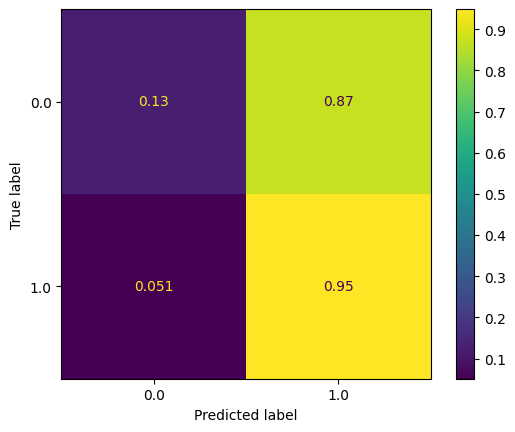

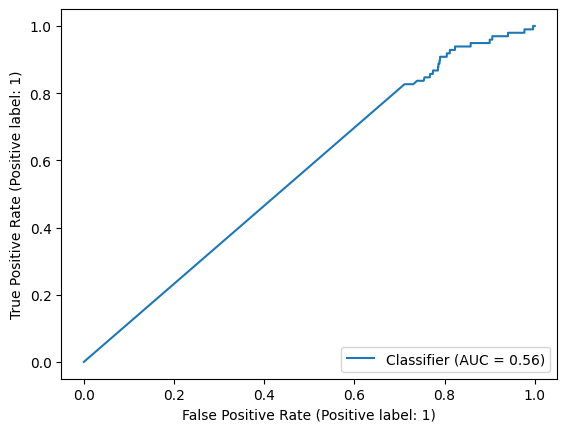

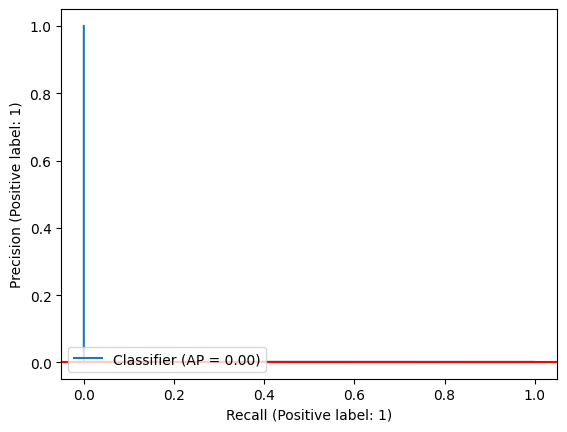

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.13      0.95      0.23      0.35      0.11     56864
        1.0       0.00      0.95      0.13      0.00      0.35      0.13        98

avg / total       1.00      0.13      0.95      0.23      0.35      0.11     56962

AUPRC: 0.4144187403120531
AP: 0.001981131846537749


In [19]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=300)
fw_model.evaluate(df_test, confidence=0.90)

In [31]:
path = "vgan_model.pt"
torch.save(fw_model.model.state_dict(), path)

### LSTM-Based Detection

In [20]:
#split df_concat into train and test
ltsm_train, ltsm_test = train_test_split(df_concat, test_size=0.2, random_state=42)

In [21]:
def create_time_dataset(in_df, seq_size=10):
    X, y = [], []
    for i in range(len(in_df) - seq_size):
        slice = in_df[i:i+seq_size]
        X.append(slice.drop(['Class', 'Time'], axis=1).values)
        y.append(slice['Class'].values[-1])

    X = np.array(X)
    y = np.array(y)

    return torch.Tensor(X).to(device), torch.Tensor(y).to(device)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size = 256
        self.lstm = nn.LSTM(input_size,
                            hidden_size=self.hidden_size,
                            num_layers=5,
                            bidirectional=True,
                            batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x, hx = self.lstm(x)
        out = torch.cat((hx[0][-2, :, :], hx[0][-1, :, :]), dim=1)
        return torch.flatten(self.linear(out))

In [23]:
class LSTMFraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 128
        X_train, y_train = create_time_dataset(train_df)
        self.dataset = TensorDataset(X_train, y_train)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = LSTMModel(input_size=X_train.shape[2]).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(tqdm(self.dataloader)):
                x,y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch+1, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
        input, y_true = create_time_dataset(test_df)
        dataloader = DataLoader(TensorDataset(input, y_true), self.batch_size, shuffle=False)
        preds = np.array([])
        for (inp, _) in dataloader:
            pred = self.predict(inp)
            preds = np.concatenate((preds, pred), axis=None)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(y_true.cpu().numpy(), labels, preds)

In [24]:
lstm = LSTMFraudModel(ltsm_train)

In [25]:
lstm.train(epochs=300)

100%|██████████| 2846/2846 [01:02<00:00, 45.90it/s]


[Epoch 1/300] loss: 0.639998


100%|██████████| 2846/2846 [01:01<00:00, 46.45it/s]


[Epoch 2/300] loss: 0.090704


100%|██████████| 2846/2846 [01:01<00:00, 46.46it/s]


[Epoch 3/300] loss: 0.079597


100%|██████████| 2846/2846 [01:01<00:00, 46.43it/s]


[Epoch 4/300] loss: 0.064379


100%|██████████| 2846/2846 [01:01<00:00, 46.28it/s]


[Epoch 5/300] loss: 0.053895


100%|██████████| 2846/2846 [01:01<00:00, 46.46it/s]


[Epoch 6/300] loss: 0.044959


100%|██████████| 2846/2846 [01:01<00:00, 46.05it/s]


[Epoch 7/300] loss: 0.041178


100%|██████████| 2846/2846 [01:01<00:00, 46.26it/s]


[Epoch 8/300] loss: 0.037331


100%|██████████| 2846/2846 [01:01<00:00, 46.12it/s]


[Epoch 9/300] loss: 0.036243


100%|██████████| 2846/2846 [01:01<00:00, 46.23it/s]


[Epoch 10/300] loss: 0.034390


100%|██████████| 2846/2846 [01:01<00:00, 46.22it/s]


[Epoch 11/300] loss: 0.035192


100%|██████████| 2846/2846 [01:01<00:00, 46.16it/s]


[Epoch 12/300] loss: 0.032516


100%|██████████| 2846/2846 [01:01<00:00, 46.42it/s]


[Epoch 13/300] loss: 0.032337


100%|██████████| 2846/2846 [01:01<00:00, 46.29it/s]


[Epoch 14/300] loss: 0.030908


100%|██████████| 2846/2846 [01:01<00:00, 46.32it/s]


[Epoch 15/300] loss: 0.026335


100%|██████████| 2846/2846 [01:01<00:00, 46.39it/s]


[Epoch 16/300] loss: 0.024295


100%|██████████| 2846/2846 [01:00<00:00, 46.92it/s]


[Epoch 17/300] loss: 0.023121


100%|██████████| 2846/2846 [01:01<00:00, 46.43it/s]


[Epoch 18/300] loss: 0.023721


100%|██████████| 2846/2846 [01:01<00:00, 46.27it/s]


[Epoch 19/300] loss: 0.021222


100%|██████████| 2846/2846 [01:01<00:00, 46.25it/s]


[Epoch 20/300] loss: 0.020824


100%|██████████| 2846/2846 [01:00<00:00, 46.66it/s]


[Epoch 21/300] loss: 0.018213


100%|██████████| 2846/2846 [01:01<00:00, 46.62it/s]


[Epoch 22/300] loss: 0.017323


100%|██████████| 2846/2846 [01:00<00:00, 46.98it/s]


[Epoch 23/300] loss: 0.017224


100%|██████████| 2846/2846 [01:01<00:00, 46.61it/s]


[Epoch 24/300] loss: 0.014602


100%|██████████| 2846/2846 [01:00<00:00, 47.30it/s]


[Epoch 25/300] loss: 0.013174


100%|██████████| 2846/2846 [01:00<00:00, 46.75it/s]


[Epoch 26/300] loss: 0.014066


100%|██████████| 2846/2846 [01:00<00:00, 46.85it/s]


[Epoch 27/300] loss: 0.011853


100%|██████████| 2846/2846 [01:01<00:00, 46.24it/s]


[Epoch 28/300] loss: 0.011166


100%|██████████| 2846/2846 [01:01<00:00, 46.25it/s]


[Epoch 29/300] loss: 0.009557


100%|██████████| 2846/2846 [01:01<00:00, 46.31it/s]


[Epoch 30/300] loss: 0.008771


100%|██████████| 2846/2846 [01:00<00:00, 46.82it/s]


[Epoch 31/300] loss: 0.008709


100%|██████████| 2846/2846 [01:00<00:00, 47.13it/s]


[Epoch 32/300] loss: 0.018610


100%|██████████| 2846/2846 [01:00<00:00, 46.66it/s]


[Epoch 33/300] loss: 0.004940


100%|██████████| 2846/2846 [01:01<00:00, 46.64it/s]


[Epoch 34/300] loss: 0.007627


100%|██████████| 2846/2846 [01:00<00:00, 46.80it/s]


[Epoch 35/300] loss: 0.004527


100%|██████████| 2846/2846 [01:00<00:00, 47.15it/s]


[Epoch 36/300] loss: 0.004616


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 37/300] loss: 0.004696


100%|██████████| 2846/2846 [01:00<00:00, 47.26it/s]


[Epoch 38/300] loss: 0.003953


100%|██████████| 2846/2846 [01:00<00:00, 46.70it/s]


[Epoch 39/300] loss: 0.003053


100%|██████████| 2846/2846 [01:00<00:00, 46.73it/s]


[Epoch 40/300] loss: 0.002860


100%|██████████| 2846/2846 [01:00<00:00, 47.00it/s]


[Epoch 41/300] loss: 0.005363


100%|██████████| 2846/2846 [01:00<00:00, 46.77it/s]


[Epoch 42/300] loss: 0.001472


100%|██████████| 2846/2846 [01:00<00:00, 47.01it/s]


[Epoch 43/300] loss: 0.002692


100%|██████████| 2846/2846 [01:00<00:00, 47.24it/s]


[Epoch 44/300] loss: 0.001436


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 45/300] loss: 0.004337


100%|██████████| 2846/2846 [01:00<00:00, 46.87it/s]


[Epoch 46/300] loss: 0.006187


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 47/300] loss: 0.000809


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 48/300] loss: 0.000924


100%|██████████| 2846/2846 [01:00<00:00, 47.20it/s]


[Epoch 49/300] loss: 0.004109


100%|██████████| 2846/2846 [01:01<00:00, 46.33it/s]


[Epoch 50/300] loss: 0.003152


100%|██████████| 2846/2846 [01:00<00:00, 46.75it/s]


[Epoch 51/300] loss: 0.000520


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 52/300] loss: 0.000025


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 53/300] loss: 0.000001


100%|██████████| 2846/2846 [01:00<00:00, 47.43it/s]


[Epoch 54/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.43it/s]


[Epoch 55/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.45it/s]


[Epoch 56/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.44it/s]


[Epoch 57/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.43it/s]


[Epoch 58/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.49it/s]


[Epoch 59/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 60/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.42it/s]


[Epoch 61/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 62/300] loss: 0.004453


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 63/300] loss: 0.002626


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 64/300] loss: 0.006786


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 65/300] loss: 0.002591


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 66/300] loss: 0.000841


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 67/300] loss: 0.001129


100%|██████████| 2846/2846 [01:00<00:00, 47.08it/s]


[Epoch 68/300] loss: 0.008238


100%|██████████| 2846/2846 [01:00<00:00, 46.72it/s]


[Epoch 69/300] loss: 0.001944


100%|██████████| 2846/2846 [01:00<00:00, 47.12it/s]


[Epoch 70/300] loss: 0.002576


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 71/300] loss: 0.000994


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 72/300] loss: 0.000938


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 73/300] loss: 0.000834


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 74/300] loss: 0.002577


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 75/300] loss: 0.007292


100%|██████████| 2846/2846 [01:00<00:00, 47.25it/s]


[Epoch 76/300] loss: 0.001376


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 77/300] loss: 0.000780


100%|██████████| 2846/2846 [01:00<00:00, 47.09it/s]


[Epoch 78/300] loss: 0.002597


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 79/300] loss: 0.001725


100%|██████████| 2846/2846 [01:00<00:00, 47.13it/s]


[Epoch 80/300] loss: 0.000268


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 81/300] loss: 0.001164


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 82/300] loss: 0.000592


100%|██████████| 2846/2846 [01:00<00:00, 47.26it/s]


[Epoch 83/300] loss: 0.000035


100%|██████████| 2846/2846 [01:00<00:00, 47.41it/s]


[Epoch 84/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 85/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.46it/s]


[Epoch 86/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.17it/s]


[Epoch 87/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 88/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 89/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 90/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.44it/s]


[Epoch 91/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 92/300] loss: 0.001855


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 93/300] loss: 0.001884


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 94/300] loss: 0.000105


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 95/300] loss: 0.000001


100%|██████████| 2846/2846 [01:00<00:00, 47.43it/s]


[Epoch 96/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 97/300] loss: 0.003467


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 98/300] loss: 0.001836


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 99/300] loss: 0.000186


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 100/300] loss: 0.002111


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 101/300] loss: 0.001890


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 102/300] loss: 0.000020


100%|██████████| 2846/2846 [01:00<00:00, 47.42it/s]


[Epoch 103/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 104/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.44it/s]


[Epoch 105/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 106/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 107/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.45it/s]


[Epoch 108/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 109/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.50it/s]


[Epoch 110/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 111/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.47it/s]


[Epoch 112/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 113/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 114/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 115/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.25it/s]


[Epoch 116/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 117/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 118/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 119/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 120/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 121/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 122/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 123/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 124/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]


[Epoch 125/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 126/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 127/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 128/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 129/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 130/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 131/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.26it/s]


[Epoch 132/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 133/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 134/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 135/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.46it/s]


[Epoch 136/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 137/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 138/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 139/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.30it/s]


[Epoch 140/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.30it/s]


[Epoch 141/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 142/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 143/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 144/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 145/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.26it/s]


[Epoch 146/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 147/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 148/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 149/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 150/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.14it/s]


[Epoch 151/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 152/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 153/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 154/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.26it/s]


[Epoch 155/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 156/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 157/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 158/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 159/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 160/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]


[Epoch 161/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 162/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 163/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 164/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 165/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.11it/s]


[Epoch 166/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 167/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 168/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 169/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 170/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 171/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 172/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.15it/s]


[Epoch 173/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 174/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 175/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 176/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 177/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.08it/s]


[Epoch 178/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 179/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.13it/s]


[Epoch 180/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]


[Epoch 181/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 182/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.25it/s]


[Epoch 183/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 184/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.20it/s]


[Epoch 185/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 186/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.25it/s]


[Epoch 187/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 188/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 189/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 190/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 191/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 192/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.44it/s]


[Epoch 193/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 194/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.26it/s]


[Epoch 195/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.41it/s]


[Epoch 196/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 197/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 198/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 199/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 200/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.40it/s]


[Epoch 201/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 202/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.41it/s]


[Epoch 203/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 204/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 205/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 206/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 207/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 208/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 209/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 210/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 211/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.16it/s]


[Epoch 212/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 213/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 214/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 215/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 216/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 217/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.42it/s]


[Epoch 218/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 219/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.41it/s]


[Epoch 220/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.30it/s]


[Epoch 221/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 222/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 223/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 224/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 225/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 226/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.32it/s]


[Epoch 227/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.38it/s]


[Epoch 228/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 229/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.42it/s]


[Epoch 230/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 231/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 232/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 233/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 234/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.42it/s]


[Epoch 235/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 236/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.30it/s]


[Epoch 237/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 238/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.31it/s]


[Epoch 239/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.15it/s]


[Epoch 240/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 46.89it/s]


[Epoch 241/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.01it/s]


[Epoch 242/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.18it/s]


[Epoch 243/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]


[Epoch 244/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.45it/s]


[Epoch 245/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 246/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 247/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 248/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 249/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 250/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 251/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 252/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 253/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 254/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.39it/s]


[Epoch 255/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.34it/s]


[Epoch 256/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.43it/s]


[Epoch 257/300] loss: 0.000000


100%|██████████| 2846/2846 [00:59<00:00, 47.49it/s]


[Epoch 258/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 259/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.29it/s]


[Epoch 260/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.10it/s]


[Epoch 261/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.30it/s]


[Epoch 262/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.14it/s]


[Epoch 263/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.14it/s]


[Epoch 264/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 265/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 266/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 267/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.06it/s]


[Epoch 268/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.15it/s]


[Epoch 269/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 270/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.24it/s]


[Epoch 271/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.25it/s]


[Epoch 272/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]


[Epoch 273/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.07it/s]


[Epoch 274/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.16it/s]


[Epoch 275/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 276/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.16it/s]


[Epoch 277/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.20it/s]


[Epoch 278/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.12it/s]


[Epoch 279/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]


[Epoch 280/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.14it/s]


[Epoch 281/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 282/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.20it/s]


[Epoch 283/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 284/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 285/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.17it/s]


[Epoch 286/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.20it/s]


[Epoch 287/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.33it/s]


[Epoch 288/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.20it/s]


[Epoch 289/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.36it/s]


[Epoch 290/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.23it/s]


[Epoch 291/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.35it/s]


[Epoch 292/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.19it/s]


[Epoch 293/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.27it/s]


[Epoch 294/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.37it/s]


[Epoch 295/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.25it/s]


[Epoch 296/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.28it/s]


[Epoch 297/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.16it/s]


[Epoch 298/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.22it/s]


[Epoch 299/300] loss: 0.000000


100%|██████████| 2846/2846 [01:00<00:00, 47.21it/s]

[Epoch 300/300] loss: 0.000000


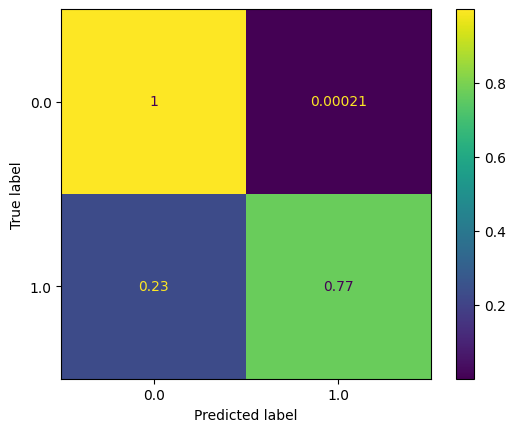

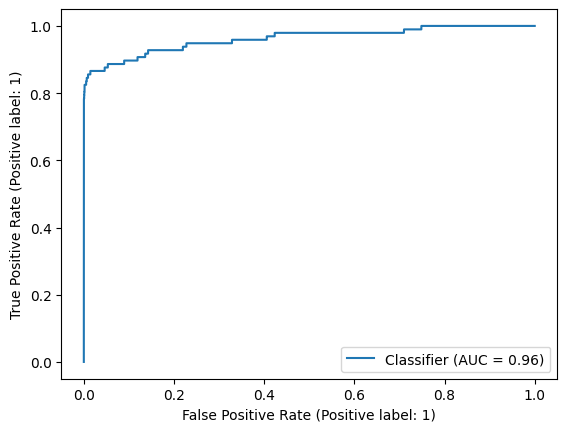

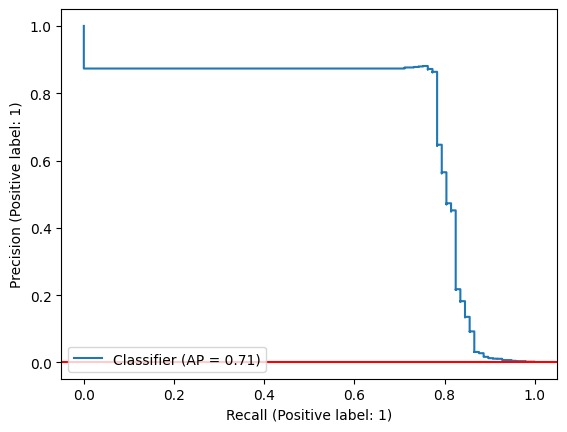

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      0.77      1.00      0.88      0.79     56855
        1.0       0.86      0.77      1.00      0.82      0.88      0.76        97

avg / total       1.00      1.00      0.77      1.00      0.88      0.79     56952

AUPRC: 0.7592918949329222
AP: 0.7144462391623738


In [35]:
lstm.evaluate(df_test,confidence=0.9)

In [38]:
path = "lstm_model.pth"
torch.save(lstm.model.state_dict(), path)
